Functions for detecting change points in the cross section profiles.
Two approaches: piecewise linear regression, detect peaks in smoothed curvature. 
In this case, curvature is the second derivative of the elevation profile, and not curvature from the elevation map directly. 

Then need to figure out the elevation of the valley bottom from these results.


Useful resources:
- https://gurobi-optimization-gurobi-optimods.readthedocs-hosted.com/en/latest/mods/lad-regression.html
- https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/how-change-point-detection-works.htm#:~:text=Slope%20(Linear%20trend)%E2%80%94Detects,having%20the%20same%20standard%20deviation.
- https://stackoverflow.com/questions/47519626/using-numpy-scipy-to-identify-slope-changes-in-digital-signals
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html
- https://docs.scipy.org/doc/scipy/reference/signal.html
- https://github.com/deepcharles/ruptures


functions to implement:
- slope threshold (done)
- piece wise analysis regression (ols, lad)
- curvature analysis peak   (done)
- curvature analysis waveform  (done)
- change point detection


In [3]:
import os

import pandas as pd
import shapely
from shapely.geometry import Point, Polygon, LineString
from shapely import wkt
import rasterio
import rioxarray
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import UnivariateSpline
import xrspatial

from valleys.cross_section import _get_extent

In [4]:
def get_profile(points, csid):
    return points.loc[points['cross_section'] == csid]
    
def fix_alphas(points):
    # if the stream centerline was smoothed, 
    # then the starting point (alpha == 0) may not be where the stream was (elevation = 0)
    # need to find that point, and adjust the alpha values accordingly 

    # could use the streamline and find the nearest point
    temp = points.copy()

    offsets = {}
    for ind in temp['cross_section'].unique():
        df = temp.loc[points['cross_section'] == ind]
        min_ind = df['elevation'].idxmin()
        center = np.where(df['alpha'] == 0)
        
        temp.loc[temp['cross_section'] == ind, 'alpha'] = (df['alpha'] - df['alpha'][min_ind])
    
    return temp
    
def _get_spline(half_profile):
    y_spl = UnivariateSpline(half_profile['alpha'], half_profile['elevation'], s=0, k=3)
    y_spl_1d = y_spl.derivative(n=1)
    y_spl_2d = y_spl.derivative(n=2)
    return {'spline': y_spl(half_profile['alpha']), 'slope': y_spl_1d(half_profile['alpha']),
            'curvature': y_spl_2d(half_profile['alpha'])}

def get_break_points_cwt(half_profile, wavelet=signal.ricker, widths=np.arange(5,15)):
    """ 
    create spline, compute second derivative, find peaks of wavelet convolution
    of second derivative at several widths 
    """
    spline = _get_spline(half_profile)
    peak_inds = signal.find_peaks_cwt(spline['curvature'], widths=widths, wavelet=wavelet)
    return half_profile.iloc[peak_inds]

def get_break_points_curv(half_profile, height=0.05):
    spline = get_spline(half_profile)
    peak_inds = signal.find_peaks(spline['curvature'], height=height)[0]
    return half_profile.iloc[peak_inds]

def get_break_point_slope(half_profile, slope_threshold=20):
    # slope refers to actual slope on the map not derivative of elevation profile

    threshold = half_profile['slope'] > slope_threshold
    # if alphas are negative go the other way
    if half_profile['alpha'].mean() < 0:
        return np.argmax(threshold[::-1])
    else:
        return np.argmax(threshold)

def _polygonize_raster_bounds(raster):
    exists = raster.where(np.isnan(raster), 1)

    exists.rio.to_raster("temp.tif", dtype="float32")

    with rasterio.open("temp.tif") as src:
        data = src.read(1)

    mask = (data == 1)
    shapes = rasterio.features.shapes(data, mask, transform=src.transform)

    records = []
    for shape, id in shapes:
        coords = shape['coordinates'][0]
        polygon = shapely.Polygon(coords)
        records.append({"geometry": polygon, "id": id})
    df = gpd.GeoDataFrame.from_records(records)

    # cleanup
    os.remove("temp.tif")
    return df['geometry'].iloc[np.argmax(df['geometry'].area)]

def _preprocess_linestring(polygon, linestring):
    # guarantee that the linestring bisects the polygon
    first = Point(linestring.coords[0])
    last = Point(linestring.coords[-1])
    
    nearest_to_first = shapely.ops.nearest_points(polygon, first)[0]
    nearest_to_last = shapely.ops.nearest_points(polygon, last)[0]
    
    linestring = LineString([Point(nearest_to_first.x + 2, nearest_to_first.y + 2), *linestring.coords])
    linestring = LineString([*linestring.coords, Point(nearest_to_last.x + 2, nearest_to_last.y + 2)])
    return linestring

def _get_side_polygons(raster, linestring):
    polygon = _polygonize_raster_bounds(raster)
    linestring = _preprocess_linestring(polygon, linestring)
    splits = shapely.ops.split(polygon, linestring)
    if len(splits.geoms) > 2:
        geometry_sequence = splits.geoms
        areas = [geometry.area for geometry in geometry_sequence]
        indices_of_largest_areas = sorted(range(len(areas)), key=lambda k: areas[k], reverse=True)[:2]
        largest_geometries = [geometry_sequence[i] for i in indices_of_largest_areas]
        return largest_geometries[0], largest_geometries[1]
    side_a = splits.geoms[0]
    side_b = splits.geoms[1]
    return side_a, side_b

def assign_side(df, raster, linestring):
    side_a, side_b = _get_side_polygons(raster, linestring)
    in_a = df.geometry.within(side_a)
    in_b = df.geometry.within(side_b)
    df['side'] = ""
    df.loc[in_a, "side"] = 'A'
    df.loc[in_b, "side"] = 'B'
    return df


In [5]:
# load example signals (elevation and slope profiles)
hand = rioxarray.open_rasterio("../toy_data/11_hand.tif").squeeze()
hand = hand.where(hand != -32768, np.nan)

dem = rioxarray.open_rasterio("../toy_data/11_dem.tif").squeeze()
dem = dem.where(dem != -32768, np.nan)

curv = rioxarray.open_rasterio("../toy_data/11_profile_curvature.tif").squeeze()
curv = curv.where(curv != -32768, np.nan)

flowline = gpd.read_file("../toy_data/11_streamline.shp")
flowline = flowline['geometry'].iloc[0]

points = pd.read_csv("../toy_data/11_cross_sections.csv", index_col=0)
points['point'] = points['point'].apply(wkt.loads)
points = gpd.GeoDataFrame(points, geometry='point', crs=3310)

points = points.loc[np.isfinite(points['elevation'])]
points = points.drop_duplicates()

points = fix_alphas(points)
points = assign_side(points, hand, flowline)

points.head()

,alpha,elevation,slope,point,cross_section,side
0,-225,119.146116,8.283040,POINT (-198329.071 -102992.189),0,A
1,-220,118.278486,9.608321,POINT (-198327.240 -102987.536),0,A
2,-215,118.203581,9.155859,POINT (-198325.410 -102982.883),0,A
3,-210,117.514051,13.163662,POINT (-198323.580 -102978.230),0,A
4,-205,117.013105,NaN,POINT (-198321.750 -102973.577),0,A


In [8]:
As = []
Bs = []

for i in points['cross_section'].unique():
    profile = get_profile(points, i)
    a_profile = profile.loc[profile['side'] == 'A']
    b_profile = profile.loc[profile['side'] == 'B']

    peak_inds_a = signal.find_peaks_cwt(a_profile['slope']*-1, widths=np.arange(2,5))
    peak_inds_b = signal.find_peaks_cwt(b_profile['slope']*-1, widths=np.arange(2,5))
    
    a_points = a_profile.iloc[peak_inds_a]['point']
    b_points = b_profile.iloc[peak_inds_b]['point']

    [As.append(p) for p in a_points]
    [Bs.append(p) for p in b_points]

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1050: RuntimeWarning: invalid value encountered in log
  fft_ops = 3 * N * np.log(N)  # 3 separate FFTs of size full_out_shape


ValueError: a cannot be empty

In [ ]:
As = gpd.GeoDataFrame(geometry=As, crs=3310)
Bs = gpd.GeoDataFrame(geometry=Bs, crs=3310)

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

cs = ax.contourf(hand, cmap='terrain', levels=25,
                     extent=_get_extent(hand), origin='upper')

As.plot(ax=ax, color='orange')
Bs.plot(ax=ax, color='blue')

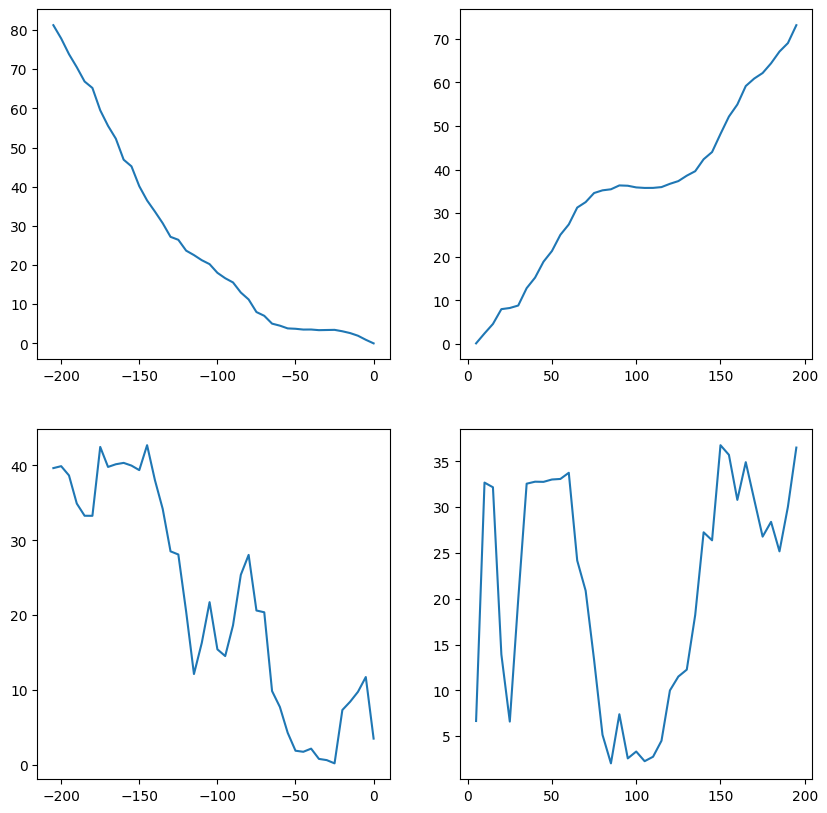

In [7]:
id = 25
prof = get_profile(points, id)
prof_a = prof.loc[prof['side'] == 'A']
prof_b = prof.loc[prof['side'] == 'B']


peaks_a = signal.find_peaks(prof_a['slope']*-1, distance=5, height=0.03)


fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].plot(prof_a['alpha'], prof_a['elevation'])
ax[0,1].plot(prof_b['alpha'], prof_b['elevation'])

ax[1,0].plot(prof_a['alpha'], prof_a['slope'])
ax[1,1].plot(prof_b['alpha'], prof_b['slope'])

In [9]:
As = []
Bs = []
heights = []
for i in points['cross_section'].unique():
    profile = get_profile(points, i)
    a_profile = profile.loc[profile['side'] == 'A']
    b_profile = profile.loc[profile['side'] == 'B']

    peaks_a = signal.find_peaks(a_profile['slope']*-1, distance=5, height=0.02)
    peaks_b = signal.find_peaks(b_profile['slope']*-1, distance=5, height=0.02)
    
    a_points = a_profile.iloc[peaks_a[0]]['point']
    b_points = b_profile.iloc[peaks_b[0]]['point']

    heights_a = a_profile.iloc[peaks_a[0]]['elevation']
    heights_b = b_profile.iloc[peaks_b[0]]['elevation']
    
    [As.append(p) for p in a_points]
    [Bs.append(p) for p in b_points]
    [heights.append(p) for p in heights_a]
    [heights.append(p) for p in heights_b]

    
As = gpd.GeoDataFrame(geometry=As, crs=3310)
Bs = gpd.GeoDataFrame(geometry=Bs, crs=3310)

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<Axes: >

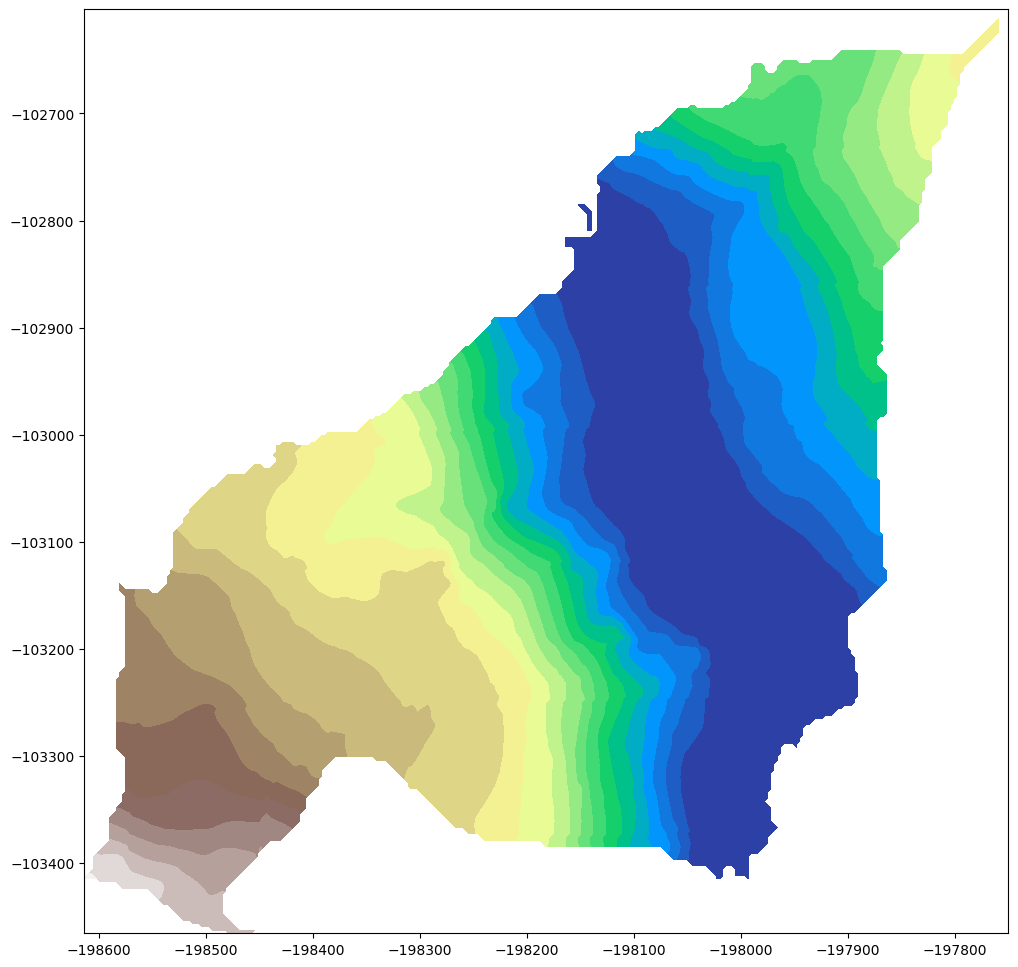

In [10]:
fig, ax = plt.subplots(figsize=(12,12))

cs = ax.contourf(hand, cmap='terrain', levels=25,
                     extent=_get_extent(hand), origin='upper')

As.plot(ax=ax, color='orange')
Bs.plot(ax=ax, color='blue')

In [ ]:
heights = pd.Series(heights)
heights.describe()

In [ ]:
h5 = (heights / 2).round().astype(int) * 2

In [211]:
h5.describe()

count    111.000000
mean      20.126126
std       25.368956
min        0.000000
25%        4.000000
50%        6.000000
75%       32.000000
max      110.000000
dtype: float64

<Axes: >

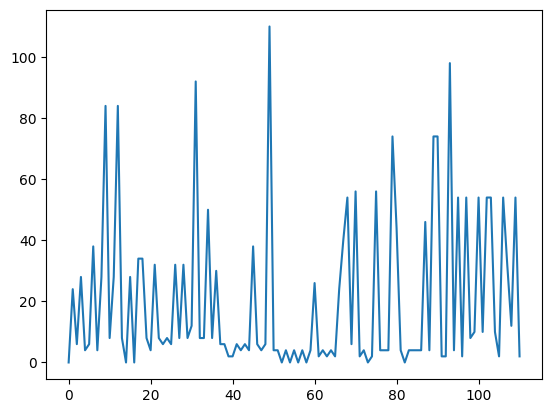

In [212]:
h5.plot()

In [213]:
h5.value_counts()

4      25
2      12
6      11
8      11
0       9
54      8
32      4
28      4
74      3
10      3
12      2
24      2
34      2
84      2
56      2
38      2
92      1
30      1
110     1
26      1
40      1
44      1
46      1
98      1
50      1
Name: count, dtype: int64